In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset
from utils.train_utils import CondOT_flow, CondOT_ut, validate
from utils.plotting import plot_flow, plot_error_for_each_point
from utils.schemes import Euler, RK4
from utils.utils import *

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
run_parameters =  yaml.safe_load(Path("./configs/base.yaml").read_text())
run_parameters

{'lr': 0.0001,
 'epochs': 15001,
 'batch_size': 1200,
 'inf_every': 1000,
 'print_every': 500,
 'dim': 2,
 'hidden_dim': 64,
 'horizon_size': 8,
 'inference_horizon': 4,
 'scale_factor': 2.0,
 'downsample': 5,
 'ema_warmup': 250,
 'ema_update': 5,
 'ema_decay': 0.999,
 'inf_runs_num': 3,
 'save_epoch': 6000,
 'device': 'cpu'}

In [3]:
sine_data = StatePyLASADataset("Sine", horizon_size=run_parameters['horizon_size'],
                                       scaling_factor=run_parameters['scale_factor'],
                                       downsample = run_parameters['downsample'])

train_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample']))

test_dataset = torch.utils.data.Subset(sine_data, range(6000//run_parameters['downsample'], 
                                                        7000//run_parameters['downsample']))

train_sin = DataLoader(train_dataset,
                       batch_size=run_parameters['batch_size'],
                       shuffle=True)

val_sin = DataLoader(test_dataset,
                    batch_size=run_parameters['batch_size'],
                    shuffle=True)

test_sin = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _ = next(iter(test_sin))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=1000//run_parameters['downsample'],
                    shuffle=False)

gt_obs, gt_horizon = next(iter(gt_test))
gt_obs = gt_obs[:, :2]

In [4]:
vf = StateMLP(
    action_dim=run_parameters['dim'],
    hidden_dim=run_parameters['hidden_dim'],
    horizon_size=run_parameters['horizon_size'],
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema_decay'],
)

obs, a = next(iter(train_sin))
print(obs.shape, a.shape)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable param number:", params)

torch.Size([1200, 5]) torch.Size([1200, 8, 2])
Learnable param number: 40864


In [5]:
device = run_parameters['device']
vf.to(device)

optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['lr'])

start_time = time.time()
for i in range(run_parameters['epochs']):
  for batch in train_sin:
    optim.zero_grad()

    obs, a1 = batch
    obs, a1 = obs.to(device), a1.to(device)

    a0 = torch.randn(a1.shape[0], 1, a1.shape[2])
    a0 = a0.repeat(1, a1.shape[1], 1).to(device)

    #a0 = torch.randn_like(a1)
    t = torch.rand(a1.shape[0]).to(device)

    a_t = CondOT_flow(a0, a1, t)
    da_t = CondOT_ut(a0, a1, t)

    loss = torch.pow(vf(obs=obs, x=a_t, t=t) - da_t, 2).mean()

    loss.backward()
    optim.step()
    if i > run_parameters['ema_warmup'] and i % run_parameters['ema_update'] == 0: 
      ema_vf.update()

  if i % run_parameters['print_every'] == 0:
      elapsed = time.time() - start_time
      print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
            .format(i, elapsed*1000/run_parameters['print_every'], loss.item()))
      start_time = time.time()
      with torch.no_grad():
        ema_vf.store()
        ema_vf.copy_to()
        loss_val = validate(vf, val_sin)
        ema_vf.restore()  # Restore original weights
        print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val))
  if i > 0 and i % run_parameters['save_epoch'] == 0:
    print("Saving checkpoint for " + str(i) + "th epoch")
    torch.save(vf.state_dict(), "./vf_lipman" + str(run_parameters['scale_factor']) + "_" + str(i) + ".pth")

  if i % run_parameters['inf_every'] == 0:
    with torch.no_grad():
      ema_vf.store()
      ema_vf.copy_to()
      results = []
      samples = []
      for _ in range(run_parameters['inf_runs_num']):
        res, samp = infer_model(model=vf,
                                start=inf_obs,
                                scheme=RK4,
                                inference_horizon=run_parameters['inference_horizon'],
                                sample_points=1000//run_parameters['downsample'])
        results.append(res)
        samples.append(samp)
      error = evaluate_model(model=vf, 
                             gt_obs=gt_obs,
                             horizon_obs=gt_horizon,
                             scheme=RK4, 
                             num_steps=100)
      plot_flow(results, samples, gt_obs)
      plot_error_for_each_point(gt_obs, error)
      ema_vf.restore()


| iter      0 |  0.06 ms/step | loss    2.265 
| iter      0 | validation loss:    2.465 


 84%|████████▍ | 42/50 [00:03<00:00, 13.92it/s]


KeyboardInterrupt: 

In [7]:
torch.save(vf.state_dict(), "./vf_euclidean" + str(run_parameters['scale_factor']) + "_" + str(20000) + ".pth")

In [6]:
vf.load_state_dict(torch.load("./vf_euclidean2.0_20000.pth", weights_only=True))

<All keys matched successfully>

100%|██████████| 50/50 [00:03<00:00, 14.38it/s]


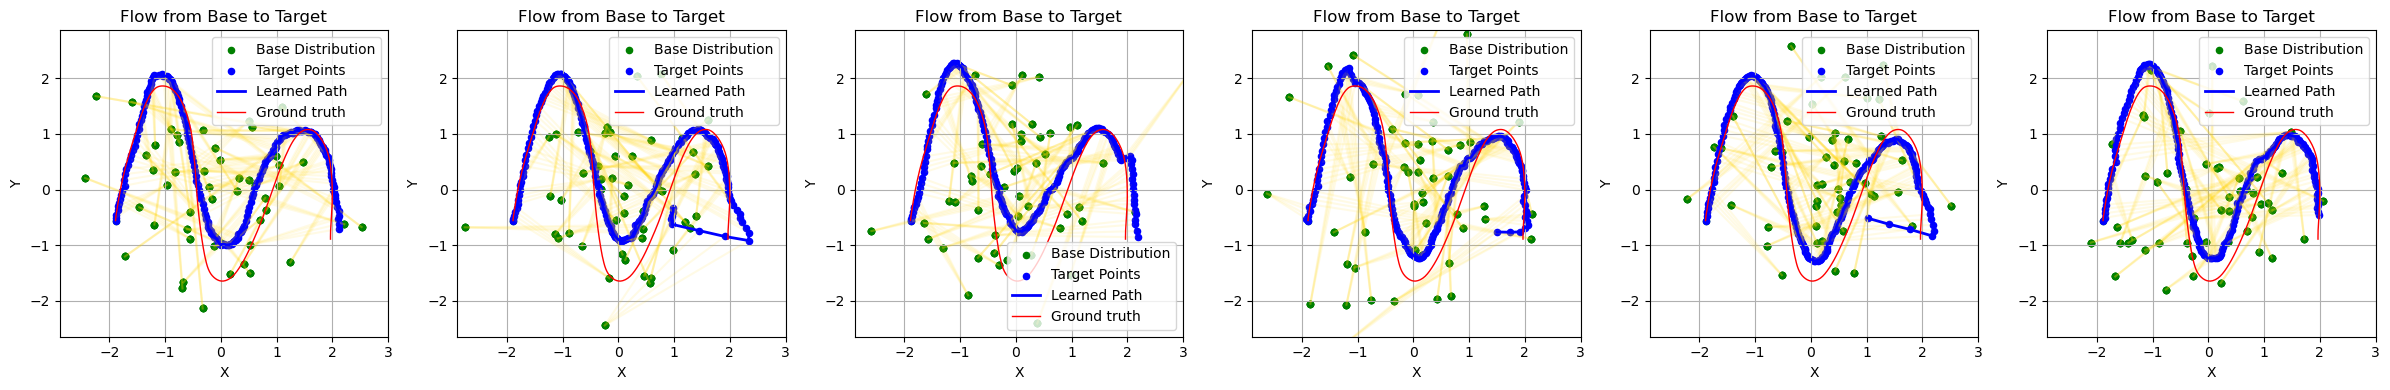

In [7]:
results=[]
samples=[]
for _ in range(6):
        res, samp = infer_model(model=vf,
                                start=inf_obs,
                                scheme=RK4,
                                inference_horizon=run_parameters['inference_horizon'],
                                sample_points=1000//run_parameters['downsample'])
        results.append(res)
        samples.append(samp)
plot_flow(results, samples, gt_obs)

In [9]:
res_tens = torch.stack(results, dim=0)
samp_tens = torch.stack(samples, dim=0)
res_tens = res_tens[1:, :, :]
samp_tens = samp_tens[1:, :, :]
torch.save(res_tens,"euclidean_inference.pt")
torch.save(samp_tens,"euclidean_samples.pt")